## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.You only need to compute these once

* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view"). Pick four points in a trapezoidal shape (similar to region masking)
* Detect lane pixels and fit to find the lane boundary.
  1. Plotting a histogram of where the binary activations occur across the image
  2. then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go
  3. Fit a polynomial

* Determine the curvature of the lane and vehicle position with respect to center (https://www.intmath.com/applications-differentiation/8-radius-curvature.php). Keep in mind
  1. the lane is about 30 meters long and 3.7 meters wide
  2. minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each
  3. our camera image has 720 relevant pixels in the y-dimension (remember, our image is perspective-transformed!)
  4. and we'll say roughly 700 relevant pixels in the x-dimension (the example of fake generated data used from 200 pixels on the left to 900 on the right, or 700).
  
#### Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension.
xm_per_pix = 3.7/700 # meters per pixel in x dimension.

  
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Sanity Check
* Checking that they have similar curvature
* Checking that they are separated by approximately the right distance horizontally
* Checking that they are roughly parallel


---


## Import Packages

In [19]:
#doing all the relevant imports
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import matplotlib.image as mpimg
import numpy as np
import cv2 #bringing in OpenCV libraries

import math

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os


## First, I'll compute the camera calibration using chessboard images

The calibration images were taken with a different camera setting and a different chessboard pattern than the calibration images for the lessons. I to set the chessboard size to 9x6 for the project instead of 8x6 as in the lessons.

In [49]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        mpimg.imsave('output_images/camera_cal_output/calibration'+str(idx)+'.jpg', img)        
        cv2.waitKey(500)

cv2.destroyAllWindows()

#### Now we have `objpoints` and `imgpoints` needed for camera calibration.  Then we have to calibrate, calculate distortion coefficients, and test undistortion on an image!

Text(0.5, 1.0, 'Undistorted Image')

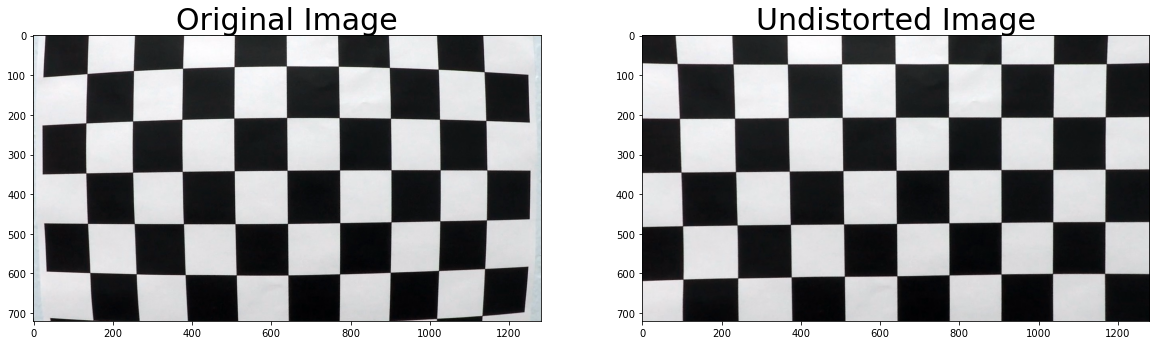

In [50]:
import pickle
%matplotlib inline

img_size = (1280, 720)
# Do camera calibration given object points and image points
# Save the camera calibration result for later use (only mtx & dist, we won't worry about rvecs / tvecs)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/camera_cal_output/test_undist.jpg',dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Apply a distortion correction to raw images and Create source and destination points to perspective transform

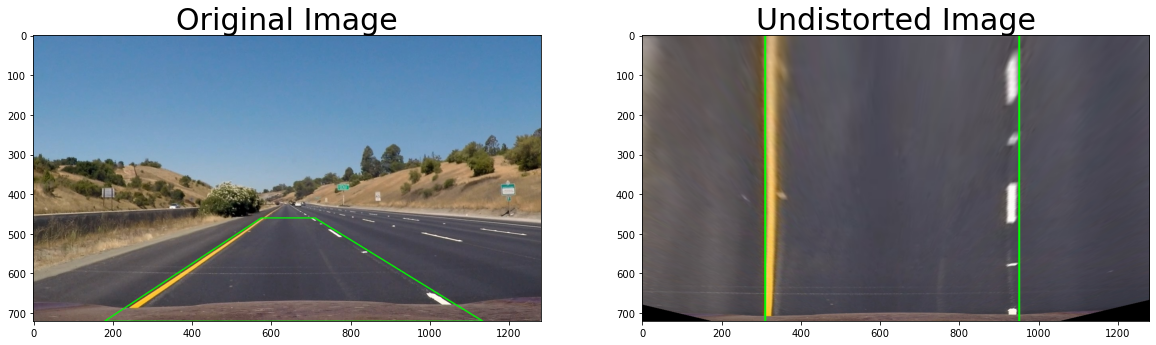

In [59]:
import cv2 #bringing in OpenCV libraries

# Read in an image
img = cv2.imread('test_images/straight_lines1.jpg')  #
# Note: always make a copy rather than simply using "="
image_original = np.copy(img)


#Undistort using mtx and dist
undistort_img = cv2.undistort(img, mtx, dist, None, mtx)

# define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 

# We are defining a four sided polygon to transform
# Visualize polygon   
vertices = [(180,720),(575, 460), (710, 460), (1133,720)]
cv2.line(image_original, vertices[0],vertices[1], color=[0, 255, 0], thickness=2)
cv2.line(image_original, vertices[1],vertices[2], color=[0, 255, 0], thickness=2)
cv2.line(image_original, vertices[2],vertices[3], color=[0, 255, 0], thickness=2)
cv2.line(image_original, vertices[0],vertices[3], color=[0, 255, 0], thickness=2)

src_perspectiveTrpoints = np.float32([[180,720],[575,460],[710,460],[1133,720]])
# define 4 destination points dst = np.float32([[,],[,],[,],[,]])
dst_perspectiveTrpoints = np.float32([[300,720],[290,50],[980,50],[950,720]]) #
# use cv2.getPerspectiveTransform() to get M, the transform matrix
perspectiveTrMatrix = cv2.getPerspectiveTransform(src_perspectiveTrpoints, dst_perspectiveTrpoints)
# e) use cv2.warpPerspective() to warp your image to a top-down view
warped = cv2.warpPerspective(img, perspectiveTrMatrix, (img.shape[1], img.shape[0])) #flags=cv2.INTER_NEAREST) keep same size as input image

# Visualize undistortion
cv2.line(warped, (310,0),(310,720), color=[0, 255, 0], thickness=3)
cv2.line(warped, (950,0),(950,720), color=[0, 255, 0], thickness=3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

mpimg.imsave("output_images/perspective_transform/PerspectiveTransformModel.jpg", cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))
mpimg.imsave("output_images/perspective_transform/PerspectiveTransformModelOutput.jpg", cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

################################################
#               Just for DEBUG
################################################
if False:
    listOfTestImages = os.listdir("test_images/")
    # This would apply perspective transform to all the files the images
    for file in listOfTestImages:    
        #Get the name of the image without the ext
        name_of_the_image, img_ext = os.path.splitext(file)

        if not img_ext == ".jpg":
            continue
    
        #Create output folder for this image if doesnt exist
        if not os.path.exists("output_images/perspective_transform/"):
            os.makedirs("output_images/perspective_transform/")
        #Undistort using mtx and dist
        img = cv2.imread("test_images/" + file)
        undst = cv2.undistort(img, mtx, dist, None, mtx)
        warped = cv2.warpPerspective(undst, perspectiveTrMatrix, (img.shape[1], img.shape[0]))
        mpimg.imsave("output_images/perspective_transform/" + name_of_the_image + img_ext, cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))


## Use color transforms, gradients, etc., to create a thresholded binary image.

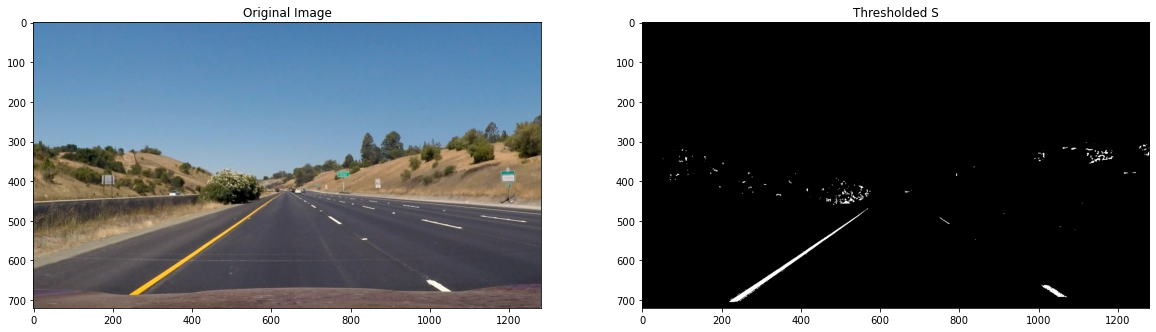

In [52]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1

    # 3) Return a binary image of threshold result
    return binary_output
    
# tune the threshold     
hls_binary = hls_select(undistort_img, thresh=(170, 255)) #90, 255

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original Image')
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('Thresholded S')
ax2.imshow(hls_binary, cmap='gray')




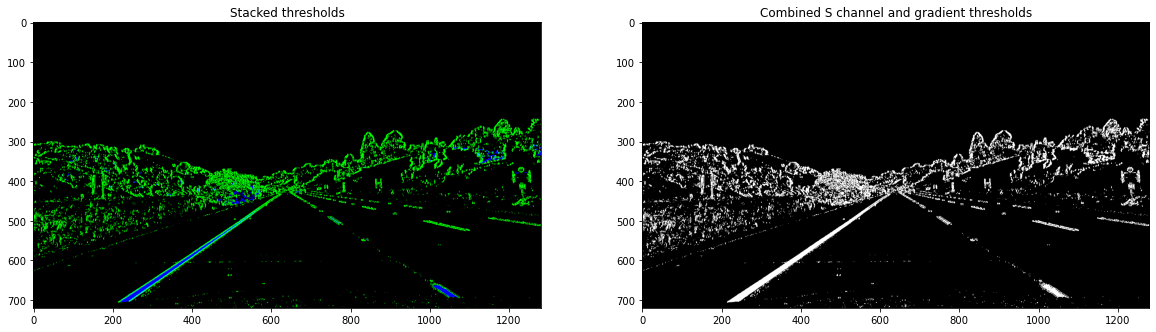

In [53]:
def color_transform2(img):
    # Note: img is the undistorted image

    ############################################
    # Yellow & White Mask
    ############################################
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)    
    
    #Yellow Mask (HSV[90,100,100] to HSV[110,255,255])
    yellow_mask = cv2.inRange(hsv_img,np.array([90, 100, 100]),np.array([110, 255, 255]))
                        
    #White mask RGB[200,200,200] to RGB[255,255,255]
    white_mask = cv2.inRange(img,np.array([200,200,200]),np.array([255, 255, 255]))
    final_mask = yellow_mask + white_mask
    img_wy = cv2.bitwise_and(img, img, mask=final_mask)
    ##################################
    # Sobel x
    ##################################
    gray = cv2.cvtColor(img_wy, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 30
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    ######################################
    # Threshold color channel
    ########################################
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds, and White & Yellow mask
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
def color_transform(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 15#30,20
    thresh_max = 100#45,100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170#180,170
    s_thresh_max = 255#200,255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

color_binary, combined_binary = color_transform(undistort_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [58]:
################################################
#               Just for DEBUG
# Apply perspective transform to binary images
# both, to only S channel binary images and to full
# color transform images
################################################
if False:
    listOfTestImages = os.listdir("test_images/")
    # This would apply perspective transform to all the files the images
    for file in listOfTestImages:    
        #Get the name of the image without the ext
        name_of_the_image, img_ext = os.path.splitext(file)

        if not img_ext == ".jpg":
            continue
    
        #Create output folder for this image if doesnt exist
        if not os.path.exists("output_images/perspective_transform/"):
            os.makedirs("output_images/perspective_transform/")
        #Undistort using mtx and dist
        img = cv2.imread("test_images/" + file)
        undst = cv2.undistort(img, mtx, dist, None, mtx)
        
        #HLS select S channel and transform perspective
        hls_binary = hls_select(undst, thresh=(90, 255))        
        warped_hls = cv2.warpPerspective(hls_binary, perspectiveTrMatrix, (img.shape[1], img.shape[0]))
        mpimg.imsave("output_images/perspective_transform/" + name_of_the_image+ '_SchannelOnly' + img_ext, warped_hls,cmap='gray')
        
        #Full color transform and transform perspective
        color_binary, combined_binary = color_transform(undst)
        warped_color_transform = cv2.warpPerspective(combined_binary, perspectiveTrMatrix, (img.shape[1], img.shape[0]))
        mpimg.imsave("output_images/perspective_transform/" + name_of_the_image+ '_FullColorTransf' + img_ext,warped_color_transform,cmap='gray')
        
        #mixed
        mixed = np.zeros_like(hls_binary)
        mixed[(hls_binary == 1) | (combined_binary == 1)] = 1        
        combined = cv2.warpPerspective( mixed , perspectiveTrMatrix, (img.shape[1], img.shape[0]))
        mpimg.imsave("output_images/perspective_transform/" + name_of_the_image+ '_Combined' + img_ext,combined,cmap='gray')
        
        nada = color_transform2(undst)
        nada = cv2.warpPerspective( nada , perspectiveTrMatrix, (img.shape[1], img.shape[0]))
        mpimg.imsave("output_images/perspective_transform/" + name_of_the_image+ '_Option2' + img_ext,nada,cmap="gray")

## histogram, sliding windows moving upward in the image, fit a polynomial

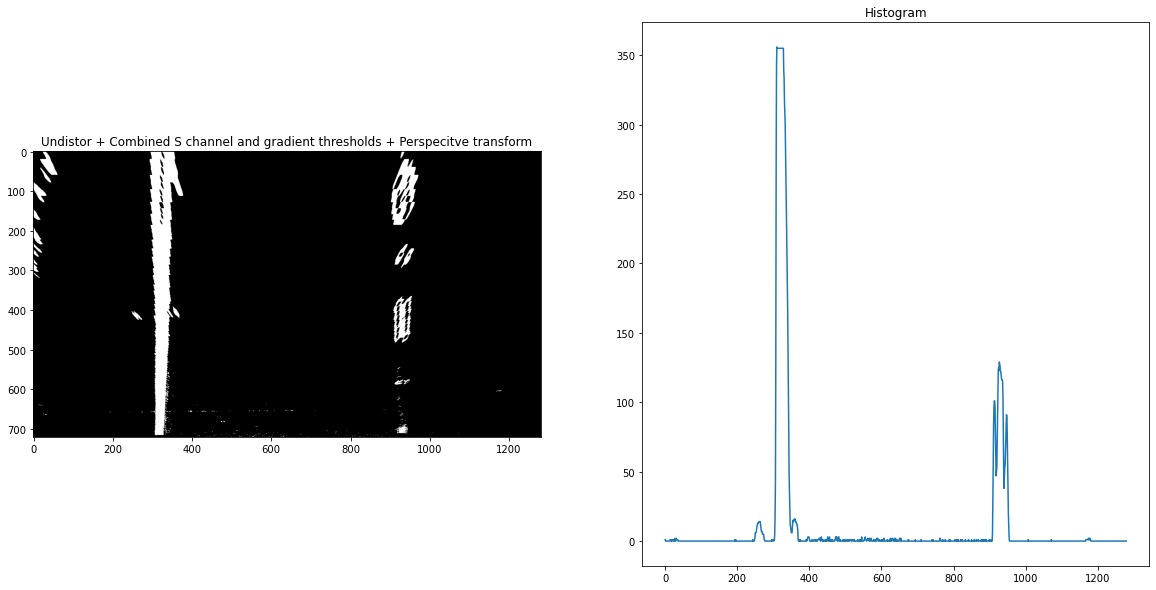

In [55]:
color_binary, combined_binary = color_transform(undistort_img)
warped = cv2.warpPerspective(combined_binary, perspectiveTrMatrix, (img.shape[1], img.shape[0]))

histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Undistor + Combined S channel and gradient thresholds + Perspecitve transform')
ax1.imshow(warped, cmap='gray')
# Visualize the resulting histogram
ax2.set_title('Histogram')
ax2.plot(histogram)


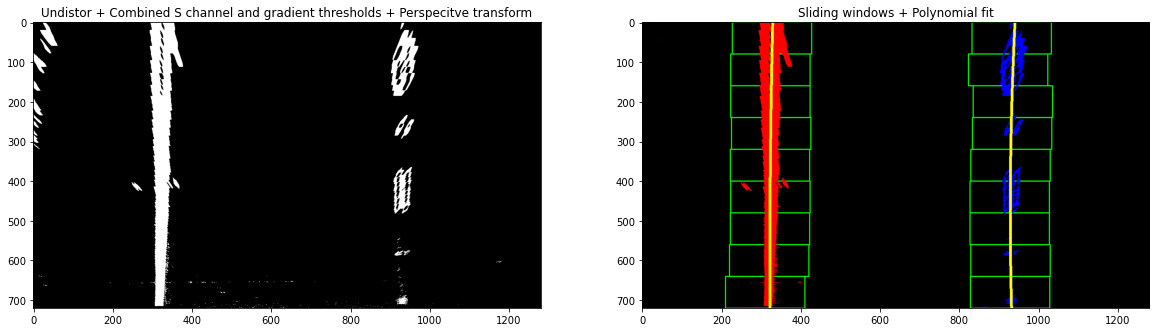

In [56]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin   # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        #Co-ordinate ordering: [x1,y1,x2,y2]
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0] 
       
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # And recast the x and y points into usable format for cv2.fillPoly()
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))

    cv2.polylines(out_img, np.int_([pts_left]), False, (255,255,0), 5)
    cv2.polylines(out_img, np.int_([pts_right]), False, (255,255,0), 5)
   
    # These Polynomial fit values will help for the next frame
    # Make sure to save them!

    return out_img

poly_slidewindows_img = fit_polynomial(warped)
# Plotting images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Undistor + Combined S channel and gradient thresholds + Perspecitve transform')
ax1.imshow(warped, cmap='gray')
# Visualize the resulting histogram
ax2.set_title('Sliding windows + Polynomial fit')
ax2.imshow(poly_slidewindows_img)


In [57]:
################################################
#               Just for DEBUG
# Apply perspective transform to full color transformed images
# Apply sliding windows and fit a polynomial
################################################
if True:
    listOfTestImages = os.listdir("test_images/")
    # This would apply perspective transform to all the files the images
    for file in listOfTestImages:    
        #Get the name of the image without the ext
        name_of_the_image, img_ext = os.path.splitext(file)

        if not img_ext == ".jpg":
            continue
    
        #Create output folder for this image if doesnt exist
        if not os.path.exists("output_images/slidewindows_poly/"):
            os.makedirs("output_images/slidewindows_poly/")
        #Undistort using mtx and dist
        img = cv2.imread("test_images/" + file)
        undst = cv2.undistort(img, mtx, dist, None, mtx)
        
        #s channel
        hls_binary = hls_select(undst, thresh=(90, 255))
        
        #Full color transform and transform perspective
        color_binary, combined_binary = color_transform(undst)
        
        #mixed
        mixed = np.zeros_like(hls_binary)
        mixed[(hls_binary == 1) | (combined_binary == 1)] = 1
        
        warped_color_transform = cv2.warpPerspective(mixed, perspectiveTrMatrix, (img.shape[1], img.shape[0]))
        poly_slidewindows_img = fit_polynomial(warped_color_transform)        
        
        mpimg.imsave("output_images/slidewindows_poly/" + name_of_the_image + img_ext,poly_slidewindows_img)




# Final stand alone program starts here

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *


In [60]:
#doing all the relevant imports
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import matplotlib.image as mpimg
import numpy as np
import cv2 #bringing in OpenCV libraries

import math

from moviepy.editor import VideoFileClip
from IPython.display import HTML

import os

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
     ## Apply a distortion correction to raw images and Create source and destination points to perspective transform   self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        #number of detected pixels
        self.px_count = None
    def Add_polynomial_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
                   self.diffs[1] > 1.0 or \
                       self.diffs[2] > 100.) and \
                           len(self.current_fit) > 0:
                # bad fit! dont use it, unless there are no fits in the current_fit queue,
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                    self.best_fit = np.average(self.current_fit, axis=0)
                else:
                    self.best_fit = fit
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
            else:
                self.best_fit = None
                
        

In [61]:

# Function that takes images to find a pattern
# performs the camera calibration, and returns the values needed to undistort images

def camera_calibration():
	# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
	objp = np.zeros((6*9,3), np.float32)
	objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

	# Arrays to store object points and image points from all the images.
	objpoints = [] # 3d points in real world space
	imgpoints = [] # 2d points in image plane.

	# Make a list of calibration images
	images = glob.glob('camera_cal/calibration*.jpg')

	# Step through the list and search for chessboard corners
	for fname in images:    
		img = cv2.imread(fname)
		gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

		# Find the chessboard corners
		ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

		# If found, add object points, image points
		if ret == True:
			objpoints.append(objp)
			imgpoints.append(corners)

	cv2.destroyAllWindows()

	img_size = (1280, 720) #Size of our images and video frame

	# Do camera calibration given object points and image points
	# Save the camera calibration result for later use (only mtx & dist, we won't worry about rvecs / tvecs)
	ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

	return objpoints, imgpoints, mtx, dist

def color_transform2(img):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    img_BThresh = np.zeros_like(hls_l)
    img_BThresh[(hls_l > 220) & (hls_l <= 255)] = 1
    
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    img_LThresh = np.zeros_like(lab_b)
    img_LThresh[((lab_b > 190) & (lab_b <= 255))] = 1
    
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    
    return combined

def color_transform(img):
    # Note: img is the undistorted image

    ##################################
    # Sobel x
    ##################################
    # Grayscale image    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 15#30  #20
    thresh_max = 100#45  #100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    ######################################
    # Threshold color channel
    ########################################
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    s_thresh_min = 170#180 #170
    s_thresh_max = 255#200 #255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #############################################################
    # Get only the S channel    
    #############################################################
    binary_S_channelOnly = np.zeros_like(s_channel)
    binary_S_channelOnly[(s_channel > 90) & (s_channel <= 255)] = 1    
    
    #mixed
    super_mixed = np.zeros_like(s_channel)
    super_mixed[(binary_S_channelOnly == 1) | (combined_binary == 1)] = 1
    
    
    return super_mixed#combined_binary

def distortion_correction(img, mtx, dist):
	#Undistort using mtx and dist
	undst = cv2.undistort(img, mtx, dist, None, mtx)
	return undst

def perspective_transform(img, M):	
	# use cv2.warpPerspective() to warp your image to a top-down view
	warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0])) #flags=cv2.INTER_NEAREST) keep same size as input image
	return warped

def find_lane_with_histogram_and_moving_windows(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #histogram = np.sum(binary_warped[:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin   # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        ### Identify the nonzero pixels in x and y within the window ###
        #Co-ordinate ordering: [x1,y1,x2,y2]
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0] 
       
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
    
    return leftx,lefty,rightx,righty,left_lane_inds, right_lane_inds

def search_around_poly(binary_warped,prev_left_fit,prev_right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # feel free to tune on your own!
    margin = 30#60   #100 Since we are on track we don't need a big window to look for

    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###    
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                    prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))
      
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    

    
    return leftx,lefty,rightx,righty,left_lane_inds, right_lane_inds



def fit_polynomial(leftx,lefty,rightx,righty):
    
    left_fit_polynomial, right_fit_polynomial = (None, None)
    
    ### Fit a second order polynomial to each with np.polyfit() ###
    if len(leftx) != 0:
        left_fit_polynomial = np.polyfit(lefty, leftx, 2)
        
    if len(rightx) != 0:
        right_fit_polynomial = np.polyfit(righty, rightx, 2)
    
    
  
    # These Polynomial fit values will help for the next frame
    # Make sure to save them!

    return left_fit_polynomial, right_fit_polynomial


def find_lane(binary_warped, left_Line, right_Line):
    #If we didn´t previously have a valid left and right fit
    #start from scratch using histogram and sliding windows
    if not left_Line.detected or not right_Line.detected:
        leftx,lefty,rightx,righty,left_inds, right_inds = find_lane_with_histogram_and_moving_windows(binary_warped)
    #Do we have previous left and right fit?
    #search around polynomial
    else:
        leftx,lefty,rightx,righty,left_inds, right_inds = search_around_poly(binary_warped, left_Line.best_fit, right_Line.best_fit)
    
    # Fit new polynomials
    left_fit_polynomial, right_fit_polynomial = fit_polynomial(leftx,lefty,rightx,righty)
    
    # Add this fit to our lines
    left_Line.Add_polynomial_fit(left_fit_polynomial, left_inds)
    right_Line.Add_polynomial_fit(right_fit_polynomial, right_inds)
    
    return left_Line, right_Line

def draw_lane(binary_warped,original_image, left_Line, right_Line, transform_Minverse):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if left_Line.best_fit is not None and right_Line.best_fit is not None:
    
        left_fitx = left_Line.best_fit[0]*ploty**2 + left_Line.best_fit[1]*ploty + left_Line.best_fit[2]
        right_fitx = right_Line.best_fit[0]*ploty**2 + right_Line.best_fit[1]*ploty + right_Line.best_fit[2]
    
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))



        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
        # Draw the lines onto the warped blank image
        plot_color = (0,0,255)

        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=plot_color, thickness=12)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=plot_color, thickness=12)
    
    if left_Line.line_base_pos > right_Line.line_base_pos:
        curvature_offset = abs(left_Line.line_base_pos)
        direction = '<--'
        text = '{:04.3f}'.format(curvature_offset) + 'm ' + direction
        cv2.putText(color_warp, text, (400,600), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
    else:
        curvature_offset = abs(right_Line.line_base_pos)
        direction = '-->'
        text = direction + '{:04.3f}'.format(curvature_offset) + 'm '
        cv2.putText(color_warp, text, (640,600), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
    
    
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, transform_Minverse, (original_image.shape[1], original_image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

def measure_curvature_real(img, left_Line, right_Line):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    y_eval = y_eval * ym_per_pix
    
    left_curverad = 0
    right_curverad = 0
    
    r_fit_x_int = 0
    l_fit_x_int = 0
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if left_Line.best_fit is not None and right_Line.best_fit is not None:
        
        left_fit = [0,0]
        right_fit = [0,0]
        ##############################
        #scale coefficients and y_eval from pixels to meters
        ##############################
        left_fit[0] = (xm_per_pix / ym_per_pix**2) * left_Line.best_fit[0]
        left_fit[1] = (xm_per_pix / ym_per_pix) * left_Line.best_fit[1]
    
        right_fit[0] = (xm_per_pix / ym_per_pix**2) * right_Line.best_fit[0]
        right_fit[1] = (xm_per_pix / ym_per_pix) * right_Line.best_fit[1]
    
        
        #Implement the calculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        
        # Now our radius of curvature is in meters        
        
        l_fit_x_int = left_Line.best_fit[0]*h**2 + left_Line.best_fit[1]*h + left_Line.best_fit[2]
        r_fit_x_int = right_Line.best_fit[0]*h**2 + right_Line.best_fit[1]*h + right_Line.best_fit[2]
        
        #If we don't have data just don't change the data from the previous frame
        
        #radius of curvature of the line in some units
        left_Line.radius_of_curvature = left_curverad 
        right_Line.radius_of_curvature = right_curverad
    
        #distance in meters of vehicle center from the line
        car_position = (img.shape[1]/2) * xm_per_pix
        
        left_Line.line_base_pos = l_fit_x_int * xm_per_pix - car_position
        right_Line.line_base_pos = car_position - r_fit_x_int * xm_per_pix
        
    return left_Line, right_Line

def draw_curvature_data(img, left_Line, right_Line):    
    
    #Curvature rad is the average of both
    curv_rad = (left_Line.radius_of_curvature + right_Line.radius_of_curvature)/2
    
    #Average center of the car between the lines         
    lane_center_position = (left_Line.line_base_pos + right_Line.line_base_pos) /2
    
    
    h = img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img, "Daniel Ocampo", (40,25), font, 1.1, (255,255,255), 2, cv2.LINE_AA)
    
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(img, text, (40,70), font, 1.1, (255,255,255), 2, cv2.LINE_AA)
    direction = 'center'
    center_dist = abs(right_Line.line_base_pos - left_Line.line_base_pos)
    if left_Line.line_base_pos > right_Line.line_base_pos:
        direction = 'right'
        
    elif left_Line.line_base_pos < right_Line.line_base_pos:
        direction = 'left'
    
    text = '{:04.3f}'.format(center_dist) + 'm ' + direction + ' of center'
    cv2.putText(img, text, (40,120), font, 1.1, (255,255,255), 2, cv2.LINE_AA)

    return img


################################################
# Camera Calibration
################################################
objpoints, imgpoints, mtx, dist = camera_calibration()

################################################
# Perspective transform points and Matriz
################################################



# define 4 source points src
transform_src = np.float32([[180,720],[575,460],[710,460],[1133,720]])
# define 4 destination points dst
transform_dst = np.float32([[300,720],[290,50],[980,50],[950,720]])
# use cv2.getPerspectiveTransform() to get M, the transform matrix
transform_M = cv2.getPerspectiveTransform(transform_src, transform_dst)
transform_Minverse = np.linalg.inv(transform_M)
 
################################################
# List to save our polynomial fit result to help
# with our next frame 
################################################   
left_Line = Line()
right_Line = Line()

videos = ['test_videos/project_video.mp4','test_videos/challenge_video.mp4','test_videos/harder_challenge_video.mp4']
indexVideo = 0
video = cv2.VideoCapture(videos[indexVideo])

#Play videos showing lines in Real Time
saveFrameIndex = 0
while True:
    ret,frame = video.read() #img = frame
    if not ret:
        #Get another video... or exit
        break

    # Note: always make a copy rather than simply using "="
    img = np.copy(frame)
    
    #Process image and show the final image as a frame
    ################################################
    # Distortion Correction
    ################################################
    undst_img = distortion_correction(img, mtx, dist)

    ################################################
    # Full color threshold transform
    ################################################
    thresholded_binary_img = color_transform(undst_img)

    ################################################
    # Perspective transform
    ################################################
    warped_img = perspective_transform(thresholded_binary_img, transform_M)

    ################################################
    # Find lane by either using a sliding window loop
    # or previous polinomial fit points
    ################################################ 
    left_Line, right_Line = find_lane(warped_img, left_Line, right_Line) 
    
    ################################################
    # Find curvature if we have found the lines
    ################################################
    left_Line, right_Line = measure_curvature_real(img, left_Line, right_Line)
        
    ################################################
    # Draw lane on top of the original image/frame
    ################################################
    frameToShow = draw_lane(warped_img, img, left_Line, right_Line, transform_Minverse)
    
    frameToShow = draw_curvature_data(frameToShow, left_Line, right_Line)
    
    cv2.imshow("frame",frameToShow)
    key = cv2.waitKey(25)
    if key == 27:#ESC Key to quit
        break;
    #Take a Picture of this frame
    elif key == 50:#2
        mpimg.imsave('result'+str(saveFrameIndex)+'.jpg', cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        saveFrameIndex = saveFrameIndex + 1
        
        
video.release()
cv2.destroyAllWindows()





# It will show a video in Real Time

# * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *
